# Cluster database tables

This notebook tries to cluster database tables by using its column names. 
All columns (not rows!) of a table will be used to build a document.
This document (stored in `DOCUMENT_CONTENT`) is then used with to different clustering models to allocate a cluster:

- Latent Dirichlet Allocation (LDA)
- k-Means 

We have data for three types of databases, with a total of more then 17'000'000 records, where each record contains the definition of one column:

- Oracle (oracle_metadata_with_lang.csv)
- MySQL (mysql_metadata_with_lang.csv)
- MSSQL (mssql_metadata_with_lang.csv)

__The input files contain the following fields:__

__DB Metadata__
| Name    | Description |
| -------- | ------- |
| UID  | Unique ID of the owning application |
| DB_TYPE | Type of the Databse (MSSQL, MySQL, Oracle) |
| INSTANCE | The instance of the Database (only MSSQL) |
| DB_NAME | The name of the database |
| SCHEMA | The schema where the table os located in the database |
| TABLE_NAME | The name of the table |
| COLUMN_NAME | The name of a single column |
| DATA_TYPE | The datatyp of the column |
| LANG | The language detected by the table name |

UID,DB_TYPE,DB_NAME,SCHEMA,TABLE_NAME,COLUMN_NAME,DATA_TYPE,LANG

Each table (and therefore also each column) is assiciated to an application in the Enterprise Application Model (EAM). This data is stored in a file called `UID_AppName_Mapping.csv`

__Application Metadata__
| Name    | Description |
| -------- | ------- |
|Anwendung|The name of the application|
|UID|Unique ID of the application    |
|Stereotyp RCH| the type application (e.g. Business-Applikation, Infrastructure) |
|Massen-CID|whether the application deals with CID|

In [1]:
!pip install pyLDAvis
!pip install wordninja
!pip install lingua-language-detector
!pip install textblob
!pip install HanTa
!pip install argostranslate


# Prepare the data files

we have metadata about MSSQL, Oracle and MySQL Instances in CSV compressed in ZIP files - these CSVs must be merged into the same structure

In [2]:
# remove the existing data files
!rm -f data/*.csv  
!rm -f data/*.txt

# unzip the data files avialable
# !unzip -o data/mssql_allprod_collumns.zip -d data/
# !unzip -o data/oracle_metadata.zip -d data/
# !unzip -o data/mysql_metadata.zip -d data/
!unzip -o data/metadata_with_lang.zip -d data/
!unzip -o data/UID_AppName_Mapping.zip -d data/

zsh:1: no matches found: data/*.txt
Archive:  data/metadata_with_lang.zip
  inflating: data/mysql_metadata_with_lang.csv  
  inflating: data/oracle_metadata_with_lang.csv  
  inflating: data/mssql_metadata_with_lang.csv  
Archive:  data/UID_AppName_Mapping.zip
  inflating: data/UID_AppName_Mapping.csv  


In [3]:
%%bash
# Prepare MSSQL data

INPUT_FILE="data/mssql_metadata_with_lang.csv"
OUTPUT_FILE="data/mssql_metadata_with_lang.csv.tmp"

head -3 $INPUT_FILE

# because the column separator is ',', we need to make sure e.g. `numeric(17,10)` is replaced with `numeric(17;10)` in the csv file
# sed -E 's/\(([^)]*),([^)]*)\)/(\1;\2)/g' ${INPUT_FILE} > ${OUTPUT_FILE}
# echo "The file ${INPUT_FILE} has been processed and saved as ${OUTPUT_FILE}"

# drop the third column ('Instance') from the csv file (it does not exist in the other files)
# Use awk to drop the third column
awk -F, 'BEGIN {OFS=","} { $3=""; sub(",,", ","); print }' ${INPUT_FILE} > ${OUTPUT_FILE}

mv ${OUTPUT_FILE} ${INPUT_FILE}
rm ${OUTPUT_FILE}

echo "The file ${INPUT_FILE} has been processed, the third column has been removed:"
head -3 $INPUT_FILE

UID,DB_TYPE,INSTANCE,DB_NAME,SCHEMA,TABLE_NAME,COLUMN_NAME,DATA_TYPE,LANG
30230,MSSQL,R0015702\RCHSCOMP02,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InRedStateMilliseconds,int,EN
30230,MSSQL,R0015702\RCHSCOMP02,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InYellowStateMilliseconds,int,EN


rm: data/mssql_metadata_with_lang.csv.tmp: No such file or directory


The file data/mssql_metadata_with_lang.csv has been processed, the third column has been removed:
UID,DB_TYPE,DB_NAME,SCHEMA,TABLE_NAME,COLUMN_NAME,DATA_TYPE,LANG
30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InRedStateMilliseconds,int,EN
30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InYellowStateMilliseconds,int,EN


In [4]:
%%bash
# prepare Oracle data
INPUT_FILE="data/oracle_metadata_with_lang.csv"
OUTPUT_FILE="data/oracle_metadata_with_lang.csv.tmp"

# the data of one table contains strange column names, remove its columns
sed '/RFA772203/d' $INPUT_FILE > $OUTPUT_FILE

mv $OUTPUT_FILE $INPUT_FILE
rm -f $OUTPUT_FILE

In [5]:
%%bash
# create the dataset to use for the analysis

# the number of records to use for each DB type, set to '-1' to use all records
NR_OF_RECORDS_EACH=50000

TARGET_FILE="data/db_metadata.csv"
echo "Creating the dataset..."

# drop the first line (column names) from the files (except the one from MSSQL)
tail -n +2 data/oracle_metadata_with_lang.csv > data/oracle_metadata.csv.tmp
tail -n +2 data/mysql_metadata_with_lang.csv > data/mysql_metadata.csv.tmp

mv data/oracle_metadata.csv.tmp data/oracle_metadata_with_lang.csv
mv data/mysql_metadata.csv.tmp data/mysql_metadata_with_lang.csv

if [ $NR_OF_RECORDS_EACH -gt 0 ]; then
    echo "Creating a small dataset with ${NR_OF_RECORDS_EACH} records of each files"
    head -${NR_OF_RECORDS_EACH} data/mssql_metadata_with_lang.csv  >  ${TARGET_FILE}
    head -${NR_OF_RECORDS_EACH} data/oracle_metadata_with_lang.csv >> ${TARGET_FILE}
    head -${NR_OF_RECORDS_EACH} data/mysql_metadata_with_lang.csv  >> ${TARGET_FILE}
else
    echo "Creating a dataset with all records of each files"
    cat data/mssql_metadata_with_lang.csv data/oracle_metadata_with_lang.csv data/mysql_metadata_with_lang.csv > ${TARGET_FILE}
fi

NR_OF_LINES=$(wc -l ${TARGET_FILE})
echo "new dataset contains ${NR_OF_LINES}"

Creating the dataset...
Creating a small dataset with 50000 records of each files
new dataset contains   147425 data/db_metadata.csv


In [6]:
# Importing the required libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import LatentDirichletAllocation
import wordninja
# from nltk.corpus import stopwords

## Load the final file

In [7]:
# Load the data
df = pd.read_csv('data/db_metadata.csv')
display(df.head())

uidMapping = pd.read_csv('data/UID_AppName_Mapping.csv')

# merge the data with the mapping data
df = df.merge(uidMapping, on='UID', how='left')

# drop unused columns
df.drop(columns=['Stereotyp RCH'], inplace=True)

# for more consistency we name the columns explicitly
new_column_names = {
    df.columns[0]: 'UID',  
    df.columns[1]: 'DB_TYPE',
    df.columns[2]: 'DB_NAME',
    df.columns[3]: 'SCHEMA',
    df.columns[4]: 'TABLE_NAME',
    df.columns[5]: 'COLUMN_NAME',
    df.columns[6]: 'DATA_TYPE',
    df.columns[7]: 'LANG',
    df.columns[8]: 'APPLICATION_NAME',
    df.columns[9]: 'MASS_CID',
}
df.rename(columns=new_column_names, inplace=True)

display(df.head())

,UID,DB_TYPE,DB_NAME,SCHEMA,TABLE_NAME,COLUMN_NAME,DATA_TYPE,LANG
0,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InRedStateMilliseconds,int,EN
1,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InYellowStateMilliseconds,int,EN
2,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InDisabledStateMilliseconds,int,EN
3,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InPlannedMaintenanceMilliseconds,int,EN
4,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InUnplannedMaintenanceMilliseconds,int,EN


,UID,DB_TYPE,DB_NAME,SCHEMA,TABLE_NAME,COLUMN_NAME,DATA_TYPE,LANG,APPLICATION_NAME,MASS_CID
0,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InRedStateMilliseconds,int,EN,System Center Operations Manager (SCOM),N
1,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InYellowStateMilliseconds,int,EN,System Center Operations Manager (SCOM),N
2,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InDisabledStateMilliseconds,int,EN,System Center Operations Manager (SCOM),N
3,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InPlannedMaintenanceMilliseconds,int,EN,System Center Operations Manager (SCOM),N
4,30230,MSSQL,OperationsManagerDW,State,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InUnplannedMaintenanceMilliseconds,int,EN,System Center Operations Manager (SCOM),N


### Drop unused data

In [8]:
# drop columns of known special tables that are not relevant for the analysis
df = df[~df['TABLE_NAME'].str.lower().str.contains('flyway') # flyway schema history
        & ~df['TABLE_NAME'].str.lower().str.contains('qrtz') # quartz scheduler
        & ~df['TABLE_NAME'].str.lower().str.contains('shedlock') # shedlock
        & ~df['TABLE_NAME'].str.lower().str.contains('jobrunr') # jobrunr
        & ~df['TABLE_NAME'].str.lower().str.contains('batch_') # spring batch
        & ~df['TABLE_NAME'].str.lower().str.contains('databasechangelog') # liquibase
        ]

# drop all columns where 'LANG' is equal to 'DE'
df = df[~df['LANG'].str.upper().str.contains('DE')]

# drop unused columns
df.drop(columns=['DB_TYPE', 'DB_NAME', 'SCHEMA', 'DATA_TYPE'], inplace=True)

In [9]:
display(df.head())

,UID,TABLE_NAME,COLUMN_NAME,LANG,APPLICATION_NAME,MASS_CID
0,30230,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InRedStateMilliseconds,EN,System Center Operations Manager (SCOM),N
1,30230,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InYellowStateMilliseconds,EN,System Center Operations Manager (SCOM),N
2,30230,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InDisabledStateMilliseconds,EN,System Center Operations Manager (SCOM),N
3,30230,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InPlannedMaintenanceMilliseconds,EN,System Center Operations Manager (SCOM),N
4,30230,StateHourly_D461F6AFA87B4259B908B29DA01EDE5C,InUnplannedMaintenanceMilliseconds,EN,System Center Operations Manager (SCOM),N


TODO:
- ~~also remove all numbers from the text~~
- ~~lowercase the text~~
- ~~add table name to DOCUMENT_CONTENT~~
- ~~german vs english~~
~~'CMZKE_KUNDE' -> KUN, should be: KUNDE~~
- german to english translation
- ~~lemmatizing ([germalemma](https://github.com/WZBSocialScienceCenter/germalemma) vs spacy vs HanoverTagger)~~

In [10]:
import re
from textblob import Word

def isShortWord(word):
    if len(word) > 3:
        return True
    return False

# noramlizes the text by:
# - Removes special characters
# - Remove numbers
# - Split the text into words
# - Remove short words
# - Lemmatise words
# - Lowercase the text
def splitToWordsAndFilter(x):
    if pd.notnull(x) and x:
        
        # remove numbers and special characters, replace them with ' '
        x = re.sub(r'[^a-zA-Z]', ' ', x)
        
        # split the words using wordninja
        words = wordninja.split(x)
        # lemmatize and filter short words
        words = [Word(word).lemmatize() for word in words if isShortWord(word)]

        # lowercase the whole text
        return ' '.join(words).lower()
    return ''

# split the column names 
df['DOCUMENT_CONTENT'] = df['COLUMN_NAME'].apply(
    lambda x: splitToWordsAndFilter(x)
)

# - Concatenate 'COLUMN_NAME' values for rows with the same 'UID'/'APPLICATION_NAME'/'TABLE_NAME' combination
# - lowercase the text
df_grouped = df.groupby(['UID', 'APPLICATION_NAME', 'TABLE_NAME', 'MASS_CID'])['DOCUMENT_CONTENT'].agg(
    lambda x: ' '.join(x)
).reset_index()


df_grouped['TABLE_NAME_CONTENT'] = df_grouped['TABLE_NAME'].apply(
    lambda x: splitToWordsAndFilter(x)
)

df_grouped['DOCUMENT_CONTENT'] = df_grouped['TABLE_NAME_CONTENT'] + ' ' + df_grouped['DOCUMENT_CONTENT']


display(df_grouped.head())

,UID,APPLICATION_NAME,TABLE_NAME,MASS_CID,DOCUMENT_CONTENT,TABLE_NAME_CONTENT
0,12,RETo (Raiffeisen Expert Tool),CASIPricing_V1_DiscountModel,J,pricing discount model bank code default globa...,pricing discount model
1,12,RETo (Raiffeisen Expert Tool),CASIPricing_V1_DiscountModelConfiguration,J,pricing discount model configuration bank code...,pricing discount model configuration
2,12,RETo (Raiffeisen Expert Tool),CASIPricing_V1_GlobalCustomerPricingParameter,J,pricing global customer pricing parameter pri...,pricing global customer pricing parameter
3,12,RETo (Raiffeisen Expert Tool),CASIPricing_V1_GlobalCustomerPricingParameterG...,J,pricing global customer pricing parameter grou...,pricing global customer pricing parameter group
4,12,RETo (Raiffeisen Expert Tool),adwCreditCheckInformation,J,credit check information idel tenant cus...,credit check information


In [11]:
# write a CSV with the table names and their split names for the further manual analysis
df_grouped[['TABLE_NAME', 'TABLE_NAME_CONTENT', 'APPLICATION_NAME', 'MASS_CID']].to_csv('table_name_content.csv', index=False)

### Split training data

In [12]:
from sklearn.model_selection import train_test_split 
import numpy as np

# create a new dataframe with UID and APPLICATION_NAME only
X = df_grouped[['UID', 'DOCUMENT_CONTENT']]
y = df_grouped[['MASS_CID']]

# Split the data into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

print(len(X_train), len(X_test))

5662 1416


In [13]:
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

# some custom stop words
custom_stop_words = ['created', 'microsoft', 'll', 've', 'item', 'type', 'code', 'id', 'key', 'value', 'date', 'time', 'status', 'flag', 'description', 'comment', 'number', 'size', 'length', 'version', 'order', 'count', 'level', 'class', 'group', 'status', 'state', 'row', 'str', 'vid', 'ext', 'set', 'rid']

# combine the custom list with the english list
final_stopwords_list = list(en_stop) + custom_stop_words

print(len(final_stopwords_list))

359


In [14]:
# make sure the variable is not used anymore
df_grouped = None

# Latent Dirichlet Allocation (LDA)

### Build Bag of Words (BoW)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_bow = CountVectorizer(stop_words=final_stopwords_list, 
                                 min_df=4, 
                                 max_df=0.75, 
                                 max_features=5000)
X_train_counts_bow = vectorizer_bow.fit_transform(X_train.DOCUMENT_CONTENT.values.astype('U'))
X_test_counts_bow = vectorizer_bow.transform(X_test.DOCUMENT_CONTENT.values.astype('U'))

Topics: 2
Training Data Perplexity (lower is better): 519.250723021646
Test Data Perplexity (lower is better): 599.6339651654257


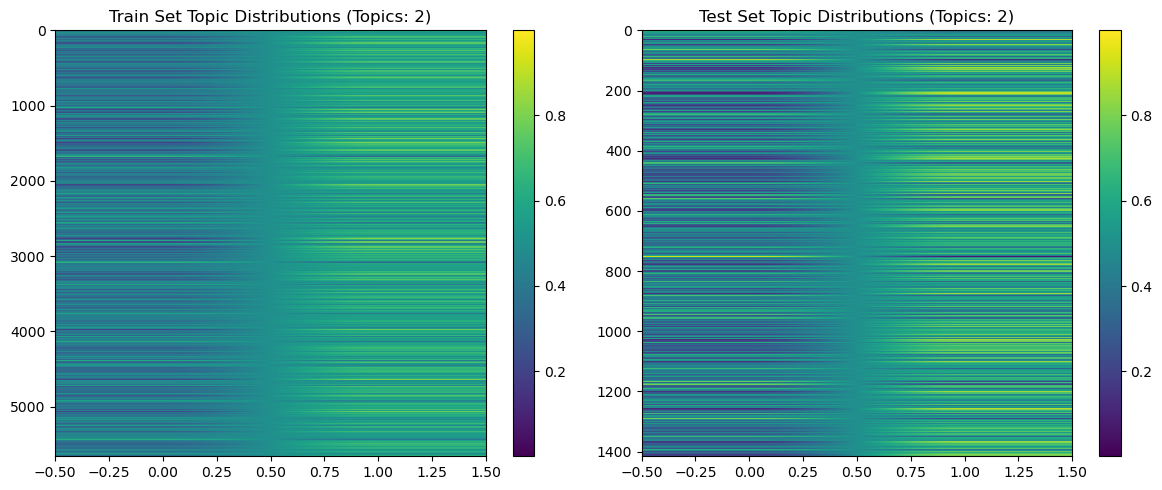

Topics: 3
Training Data Perplexity (lower is better): 454.70999410419864
Test Data Perplexity (lower is better): 554.1052679317302


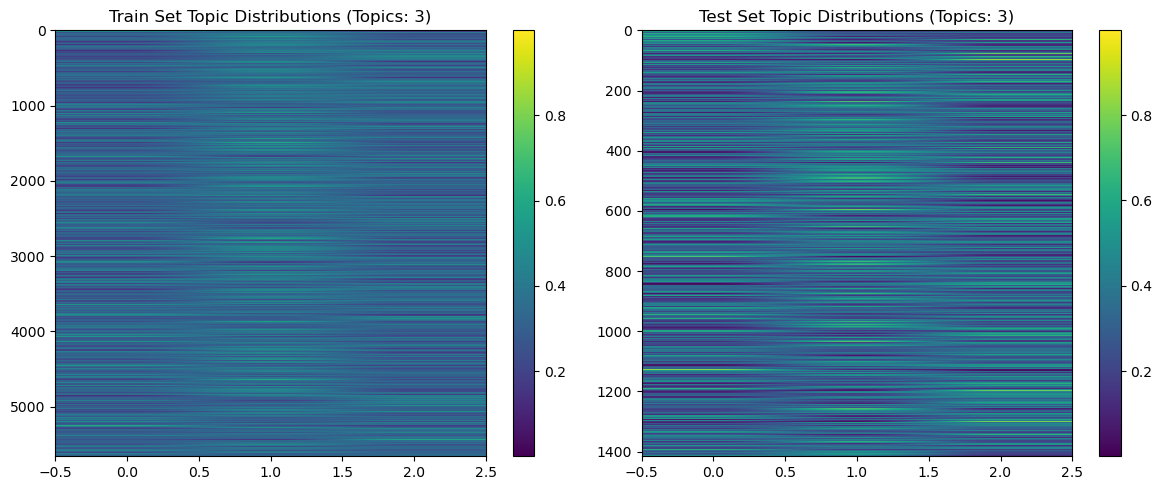

Topics: 4
Training Data Perplexity (lower is better): 410.4387178908081
Test Data Perplexity (lower is better): 516.0741523483007


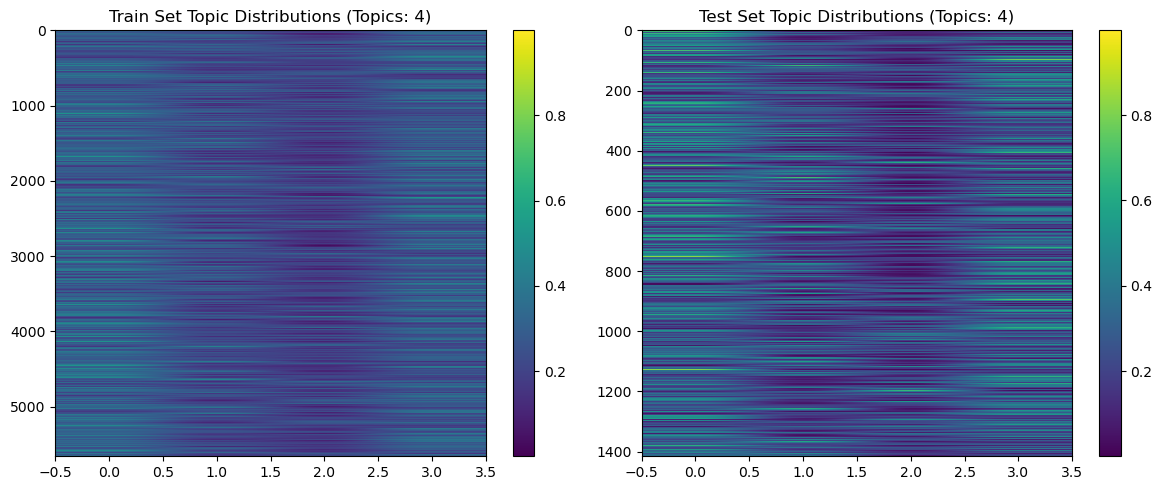

Topics: 5
Training Data Perplexity (lower is better): 381.042409490687
Test Data Perplexity (lower is better): 499.427778329115


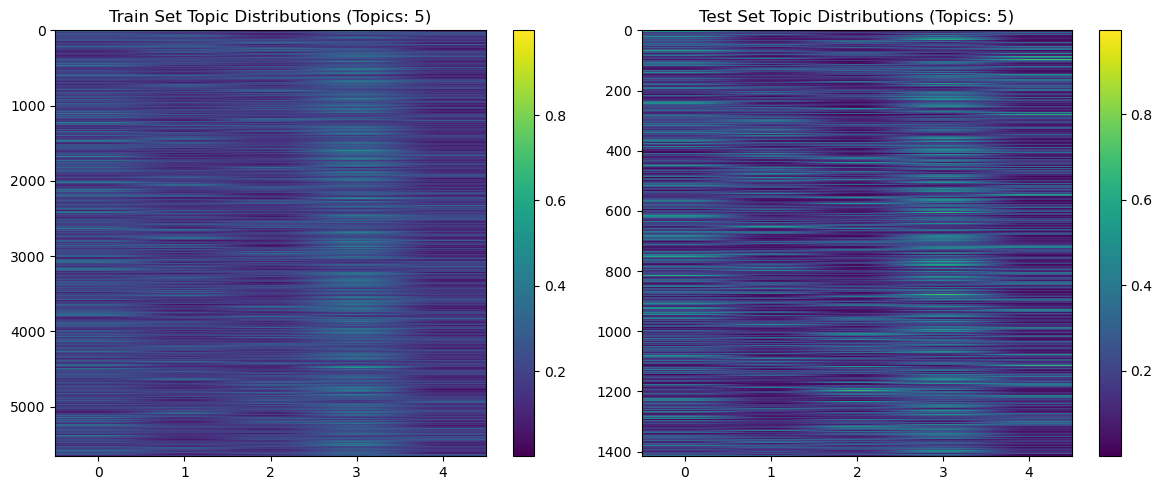

Topics: 6
Training Data Perplexity (lower is better): 374.37623603552464
Test Data Perplexity (lower is better): 500.6475110399344


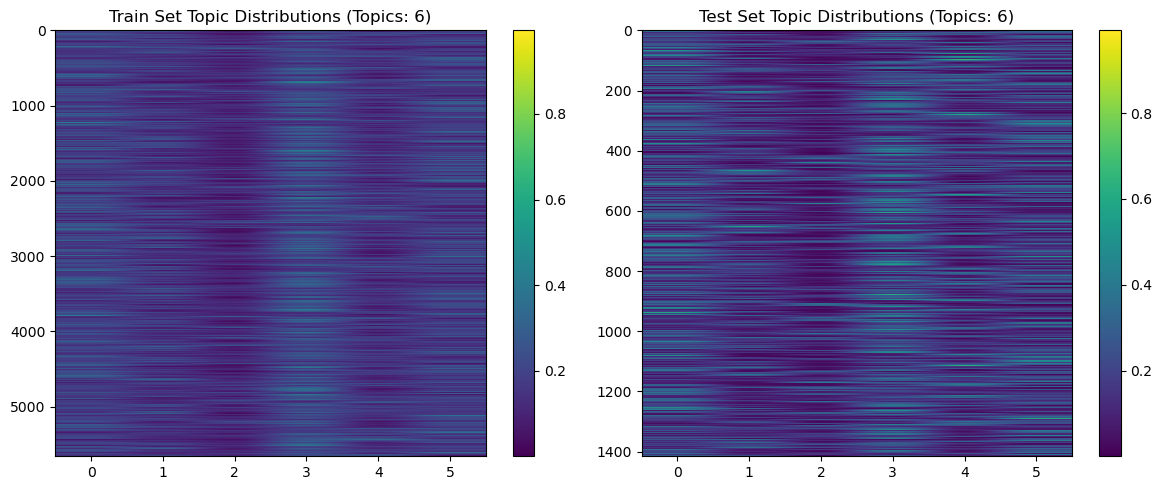

Topics: 7
Training Data Perplexity (lower is better): 351.66462934852126
Test Data Perplexity (lower is better): 481.75871570553153


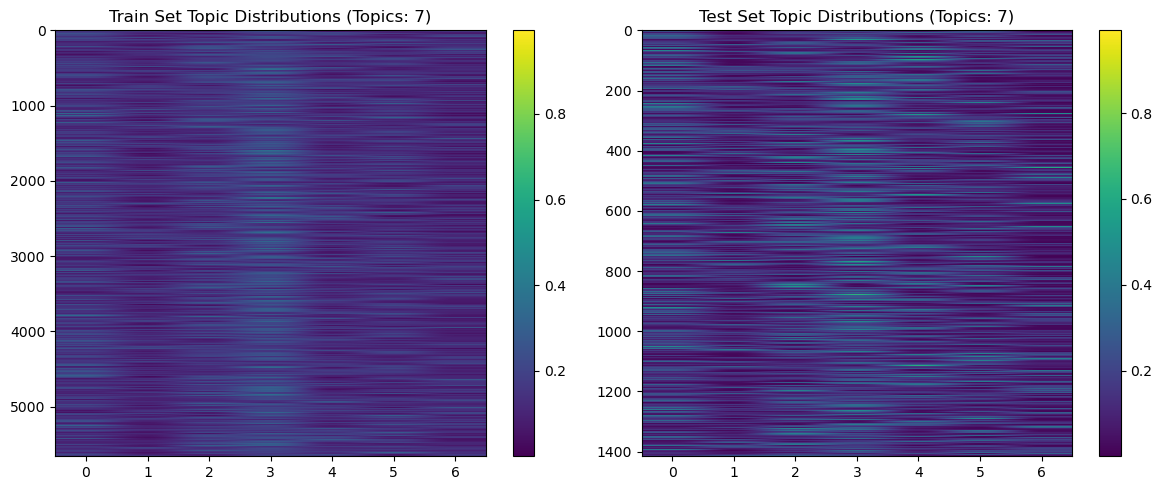

Topics: 8
Training Data Perplexity (lower is better): 355.35560034722926
Test Data Perplexity (lower is better): 510.45057115420815


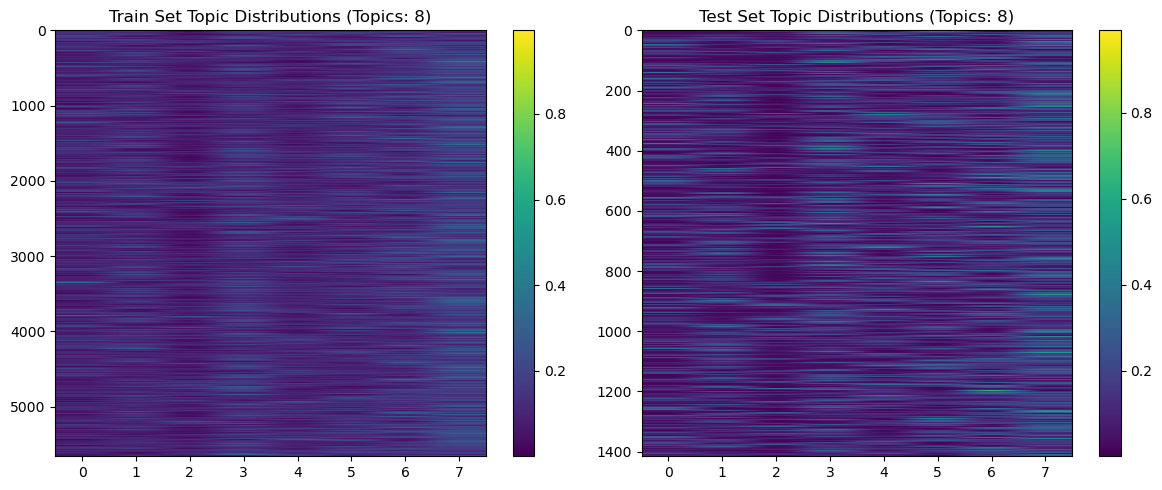

Topics: 9
Training Data Perplexity (lower is better): 332.0768169539114
Test Data Perplexity (lower is better): 469.8507317955058


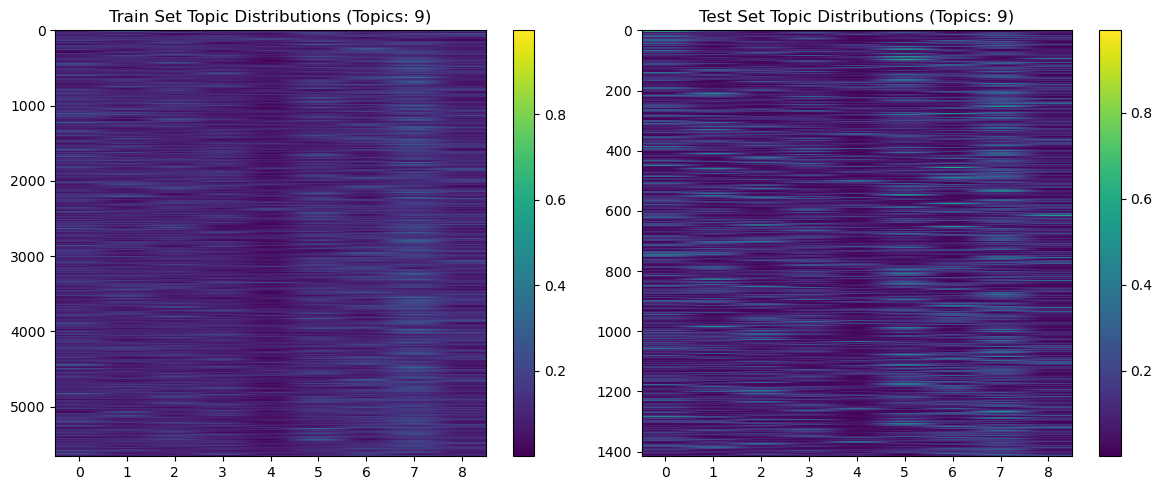

Topics: 10
Training Data Perplexity (lower is better): 329.02638055287366
Test Data Perplexity (lower is better): 465.8846942559222


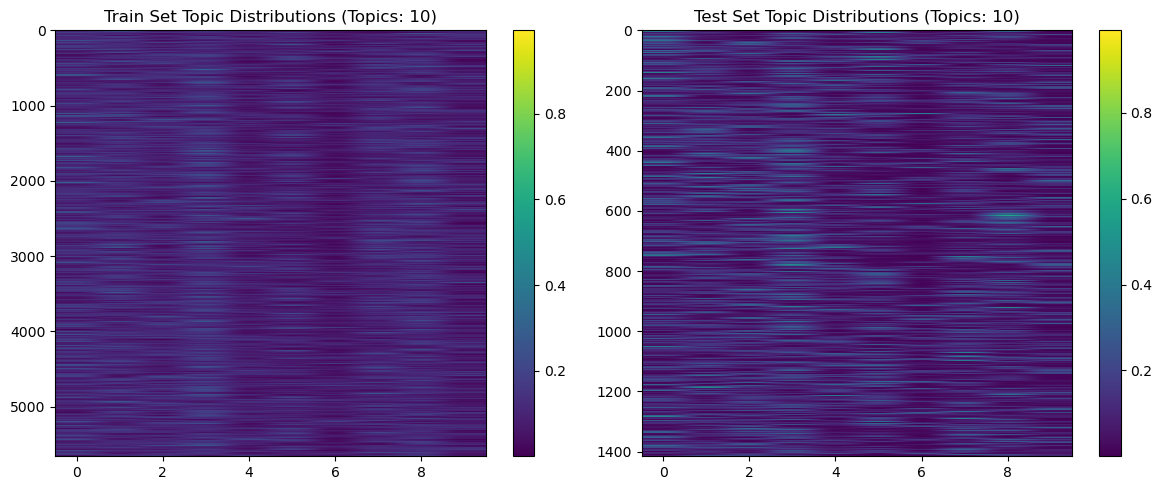

Topics: 11
Training Data Perplexity (lower is better): 321.6324099023514
Test Data Perplexity (lower is better): 456.47783774308397


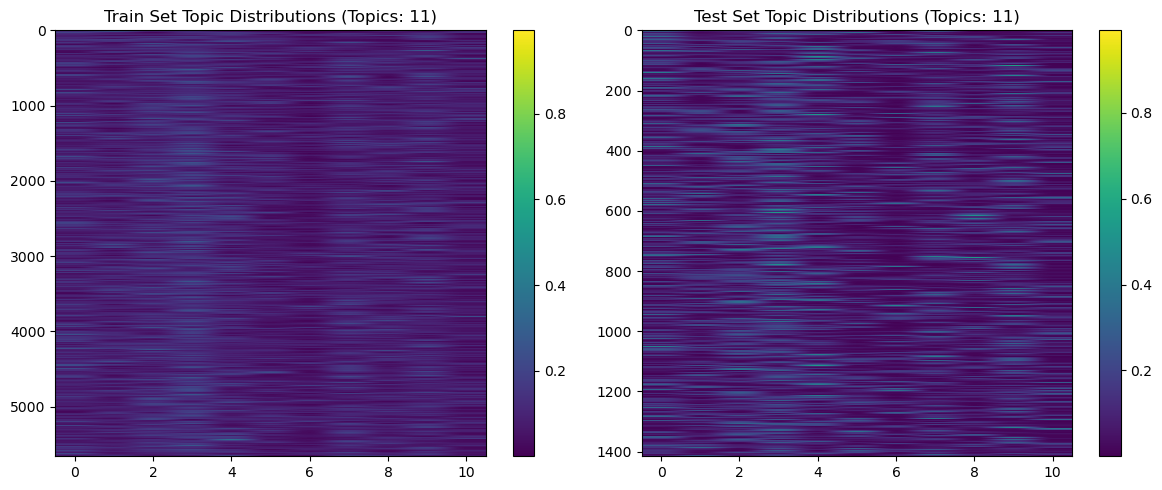

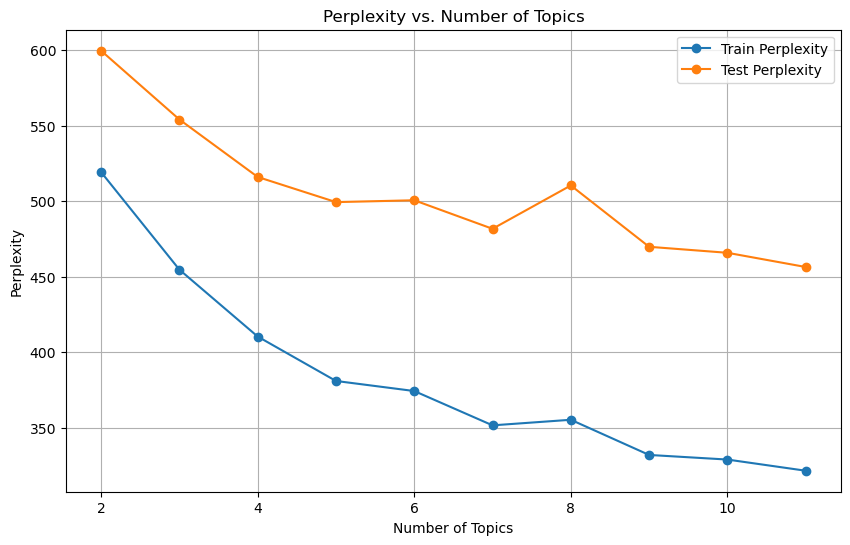

In [16]:
# Evaluate the best number of clusters with an LDA
    
number_of_max_clusters = 10

# Evaluate on both train and test sets for direct comparison
def evaluate_lda(lda_model, train_data, test_data):

    # Perplexity on training data, lower the better  (seen data)
    train_perplexity = lda_model.perplexity(train_data)
    print(f"Training Data Perplexity (lower is better): {train_perplexity}")
    
    # Perplexity on test data, lower the better (unseen data)
    test_perplexity = lda_model.perplexity(test_data)
    print(f"Test Data Perplexity (lower is better): {test_perplexity}")
    
    # return topic distributions
    train_topic_dist = lda_model.transform(train_data)
    test_topic_dist = lda_model.transform(test_data)
    
    return train_topic_dist, test_topic_dist, train_perplexity, test_perplexity

def new_lda_model(n_topics, train_data):
    lda = LatentDirichletAllocation(
        n_components=n_topics, 
        random_state=42, 
        max_iter=10,
        learning_method='online'
    )
    lda.fit(train_data)
    return lda


# vary the number of clusters and compare the perplexity
def compare_lda_models(train_doc_term_matrix, test_doc_term_matrix, max_clusters):
    n_topics_list = []
    train_perplexities = []
    test_perplexities = []
    
    for n_topics in range(2, max_clusters + 2):
        lda = new_lda_model(n_topics, train_doc_term_matrix)

        print(f"Topics: {n_topics}")

        train_topic_dist, test_topic_dist, train_perplexity, test_perplexity = evaluate_lda(lda, train_doc_term_matrix, test_doc_term_matrix)
        plot_lda_results(n_topics, train_topic_dist, test_topic_dist)

        n_topics_list.append(n_topics)
        train_perplexities.append(train_perplexity)
        test_perplexities.append(test_perplexity)
    
    return n_topics_list, train_perplexities, test_perplexities

def plot_lda_results(n_topics, train_topic_dist, test_topic_dist):
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.title(f'Train Set Topic Distributions (Topics: {n_topics})')
    plt.imshow(train_topic_dist, aspect='auto', cmap='viridis')
    plt.colorbar()

    plt.subplot(122)
    plt.title(f'Test Set Topic Distributions (Topics: {n_topics})')
    plt.imshow(test_topic_dist, aspect='auto', cmap='viridis')
    plt.colorbar()

    plt.tight_layout()
    plt.show()


n_topics_list = []
train_perplexities = []
test_perplexities = []

# run the comparison
n_topics_list, train_perplexities, test_perplexities = compare_lda_models(X_train_counts_bow, 
                                                                 X_test_counts_bow, 
                                                                 number_of_max_clusters)


# plot a graph showing the n_topics, train_perplexity, test_perplexity
# Plot the perplexities
plt.figure(figsize=(10, 6))
plt.plot(n_topics_list, train_perplexities, label='Train Perplexity', marker='o')
plt.plot(n_topics_list, test_perplexities, label='Test Perplexity', marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.title('Perplexity vs. Number of Topics')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
# Create an explicit LDA model with the number of clusters (manually selected by the output of the previous cell)
num_clusters = 5

# new trained LDA model
lda = new_lda_model(num_clusters, X_train_counts_bow)

X_train_topic_distribution, X_test_topic_distribution, _, _ = evaluate_lda(lda, X_train_counts_bow, X_test_counts_bow)

# Get the LDA cluster labels
lda_labels = X_train_topic_distribution.argmax(axis=1)

# Add the LDA cluster labels to the origin dataframe
# this allows to analyze the clusters allocation in the origin dataset manually
X_train['LDA_CLUSTER'] = lda_labels


Training Data Perplexity (lower is better): 381.042409490687
Test Data Perplexity (lower is better): 499.427778329115


ValueError: too many values to unpack (expected 2)

In [ ]:
# Display the first few rows of the dataframe with the new cluster labels
display(X_train.head())

In [ ]:
#Visualize reuslts (using https://panel.holoviz.org/)
import pyLDAvis
import pyLDAvis.lda_model

prepared_data = pyLDAvis.lda_model.prepare(lda, X_train_counts_bow, vectorizer_bow, mds='tsne', sort_topics=False, n_jobs = -1)
word_info = prepared_data.topic_info

pyLDAvis.enable_notebook()
pyLDAvis.display(prepared_data)

In [ ]:
#Print top 30 keywords of each cluster
for topic in word_info.loc[word_info.Category != 'Default'].Category.unique():
    print(topic)
    print(word_info.loc[word_info.Category.isin([topic])].sort_values('logprob', ascending = False).Term.values[:30])
    print()

# K-Means

In [ ]:

# Create a document-term matrix using TF-IDF
# tdidfVectorizer = TfidfVectorizer(stop_words=final_stopwords_list, min_df=4, max_df=0.75, max_features=5000, norm='l2')
tdidfVectorizer = TfidfVectorizer(stop_words=final_stopwords_list, 
                                  min_df=4, 
                                  max_df=0.75, 
                                  max_features=5000, 
                                  norm='l2')

X_train_doc_term_matrix = tdidfVectorizer.fit_transform(X_train.DOCUMENT_CONTENT.values.astype('U'))
X_test_doc_term_matrix = tdidfVectorizer.transform(X_test.DOCUMENT_CONTENT.values.astype('U'))

print(X_train_doc_term_matrix.shape)
print(X_test_doc_term_matrix.shape)

# the list of terms (features) in the document-term matrix
feature_names = tdidfVectorizer.get_feature_names_out()

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

# Convert the sparse matrix to a dense matrix
X_train_dense = X_train_doc_term_matrix.todense()

# Create a DataFrame from the dense matrix
tfidf_df = pd.DataFrame(X_train_dense, columns=tdidfVectorizer.get_feature_names_out())

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(tfidf_df.iloc[:100, :100], cmap='viridis')
plt.title('TF-IDF Heatmap (First 100 Documents and First 100 Terms)')
plt.xlabel('Terms')
plt.ylabel('Documents')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

scaler = StandardScaler(with_mean=False)

# predefined number of clusters to test
cluster_range = [3, 5, 8, 10, 12] 

for num_clusters in cluster_range:

    # Initialize KMeans with the desired number of clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)

    # the pipeline to execute
    pipeline = Pipeline([
        ('tfidf', tdidfVectorizer),
        ('scaler', scaler),
        ('kmeans', kmeans)
    ])

    # Fit the pipeline to the training data
    pipeline.fit(X_train.DOCUMENT_CONTENT.values.astype('U'))

    column_name = f"KMEANS_CLUSTERS_{num_clusters}"
    # Predict the clusters for the training data (seen data)
    X_train[column_name] = pipeline.predict(X_train.DOCUMENT_CONTENT.values.astype('U'))

    # Predict the clusters for the testing data (unseen data)
    X_test[column_name] = pipeline.predict(X_test.DOCUMENT_CONTENT.values.astype('U'))

    # Calculate the silhouette score for the test set (higher is better)
    silhouette_avg = silhouette_score(pipeline.named_steps['tfidf'].transform(X_test.DOCUMENT_CONTENT.values.astype('U')).toarray(), X_test[column_name])
    print(f"Cluster configuration: {num_clusters} clusters, Silhouette Score (higher is better): {silhouette_avg}")

    display(X_train.head())

    # Visualize the resulting clusters
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(pipeline.named_steps['tfidf'].transform(X_train.DOCUMENT_CONTENT.values.astype('U')).toarray())

    plt.figure(figsize=(10, 7))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=X_train[column_name], cmap='viridis', marker='o', edgecolor='k', s=50)
    plt.title(f't-SNE of TF-IDF Features ({num_clusters} clusters)')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.colorbar(label=column_name)
    plt.show()